In [83]:
import pandas as pd 

unit_1bed = pd.read_csv("../data/processed/forecast/1_bedroom_flat_forecast.csv")
unit_2bed = pd.read_csv("../data/processed/forecast/2_bedroom_flat_forecast.csv")
unit_3bed = pd.read_csv("../data/processed/forecast/3_bedroom_flat_forecast.csv")
house_2bed = pd.read_csv("../data/processed/forecast/2_bedroom_house_forecast.csv")
house_3bed = pd.read_csv("../data/processed/forecast/3_bedroom_house_forecast.csv")
house_4bed = pd.read_csv("../data/processed/forecast/4_bedroom_house_forecast.csv")

house_4bed.head()


,Suburb,2000-01,2000-04,2000-07,2000-10,2001-01,2001-04,2001-07,2001-10,2002-01,...,2027-10,2028-01,2028-04,2028-07,2028-10,2029-01,2029-04,2029-07,2029-10,2030-01
0,Albert Park-Middle Park-West St Kilda,500.0,550.0,525.0,513.0,550.0,523.0,510.0,520.0,520.0,...,1513.245816,1522.430548,1531.615279,1540.800011,1549.984742,1559.169473,1568.354205,1577.538936,1586.723668,1595.908399
1,Armadale,580.0,673.0,773.0,673.0,760.0,650.0,565.0,550.0,540.0,...,1496.888138,1505.163915,1513.381229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Carlton North,380.0,380.0,380.0,380.0,400.0,418.0,420.0,420.0,430.0,...,1478.673469,1488.571429,1498.469388,1508.367347,1518.265306,1528.163265,1538.061224,1547.959184,NaN,NaN
3,Carlton-Parkville,420.0,420.0,420.0,420.0,420.0,420.0,420.0,435.0,428.0,...,1277.512862,1285.226480,1292.940098,1300.653716,1308.367334,1316.080952,1323.794570,1331.508188,1339.221806,1346.935424
4,Collingwood-Abbotsford,310.0,320.0,330.0,345.0,350.0,350.0,350.0,360.0,380.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
def cleaning(df, name):
    list = []
    for col in df.columns:
        if col not in ['Suburb'] and col < '2025-03':
            list.append(col)

    df_cleaned = df.drop(columns=list)

    df_cleaned = df_cleaned.rename(columns={'2025-04': f'{name}_Rent_today'})

    return df_cleaned

def year_avg(df, name):
    # Create a dictionary mapping year -> list of columns for that year
    year_groups = {}
    for col in df.columns:
        if col not in ['Suburb', '2025-04']:
            year = col[:4]
            year_groups.setdefault(year, []).append(col)
    
    # Compute yearly averages
    for year, cols in year_groups.items():
        df[f"{name}_{year}_avg"] = df[cols].mean(axis=1)
    drop = []
    for col in df.columns:
        # keep only Suburb, today, and the avg column
        if col not in ['Suburb', f'{name}_Rent_today', f'{name}_avg_future_rent',] and not col.endswith('_avg'):
            drop.append(col)
    df = df.drop(columns=drop)
    return df


def growth(df, name):
    # avg of all columns except first two, as you intended
    df[f"{name}_avg_future_rent"] = df.iloc[:, 2:].mean(axis=1)

    df_growth = df

    # your formula, fixed column names
    df_growth[f'{name}_Price_change (%)'] = (
        (df_growth[f'{name}_avg_future_rent'] - df_growth[f'{name}_Rent_today'])
        / df_growth[f'{name}_avg_future_rent'] * 100
    )

    df_sorted = df_growth.sort_values(by=f'{name}_Price_change (%)', ascending=False)
    df_sorted['Suburb'] = df_sorted['Suburb'].str.upper()

    return df_sorted

def cleanPrice(name, type):
    df = pd.read_csv(f"../data/raw/{name}_prices.csv", sep=';')

    df=df.rename(columns={'Q4-2024':'Q4_2024'})

    df = df.rename(columns={'Num_sales':'Num_sales_houses'})

    columns_d=['Q3_2024', 'Q4_2024']

    units = df.rename(columns={'Q1_2025':f'{name}_price'})

    units = units.drop(columns=columns_d)

    apartments = units.merge(type, on='Suburb', how='left')

    apartments[f'{name}_Annual ROI (%)'] = apartments[f'{name}_ALL_future_rent'] * 52 / apartments[f'{name}_price'] * 100 

    apartments[f'{name}_5yr ROI (%)'] = apartments[f'{name}_Annual ROI (%)']*5

    apartments = apartments.sort_values(by=f'{name}_Annual ROI (%)', ascending=False)

    return apartments 


In [85]:
df = cleaning(house_4bed, 'house_4bed')

df1 = year_avg(df, 'house_4bed')

df2=growth(df1, 'house_4bed')

df2.head()

,Suburb,house_4bed_Rent_today,house_4bed_hous_avg,house_4bed_2025_avg,house_4bed_2026_avg,house_4bed_2027_avg,house_4bed_2028_avg,house_4bed_2029_avg,house_4bed_2030_avg,house_4bed_avg_future_rent,house_4bed_Price_change (%)
89,FERNTREE GULLY,731.672448,731.672448,759.407140,841.108056,964.270405,1087.204871,1210.045042,1286.799271,982.929605,25.562070
81,PRESTON,931.214589,931.214589,980.404306,1090.923257,1230.767734,1369.005992,1506.631580,1592.739151,1243.098087,25.089211
99,NOBLE PARK,668.085213,668.085213,698.623318,758.630767,838.973423,919.224564,999.477687,1049.639381,847.522051,21.171937
128,MILDURA,581.745307,581.745307,604.260706,648.155357,705.208191,762.515137,819.755475,855.541081,711.025893,18.182261
75,ELTHAM-RESEARCH-MONTMORENCY,846.908560,846.908560,875.161674,933.767505,1018.295710,1107.287670,1200.473034,1256.655068,1034.078460,18.100164


In [86]:
apart_1bed = growth(year_avg(cleaning(unit_1bed, 'unit_1bed'), 'unit_1bed'), 'unit_1bed')

apart_2bed = growth(year_avg(cleaning(unit_2bed, 'unit_2bed'), 'unit_2bed'), 'unit_2bed')

apart_3bed = growth(year_avg(cleaning(unit_3bed, 'unit_3bed'), 'unit_3bed'), 'unit_3bed')

merged = apart_1bed.merge(apart_2bed, on='Suburb', how='left').merge(apart_3bed, on='Suburb', how='left')

merged['apartment_ALL_avg_price_change(%)']=(merged['unit_1bed_Price_change (%)']
                                   +merged['unit_2bed_Price_change (%)']
                                   +merged['unit_3bed_Price_change (%)'])/3

merged['apartment_ALL_future_rent']=(merged['unit_1bed_avg_future_rent']
                                   +merged['unit_2bed_avg_future_rent']
                                   +merged['unit_3bed_avg_future_rent'])/3

sorted_apartments = merged.sort_values(by='apartment_ALL_avg_price_change(%)', ascending=False)

sorted_apartments.head()


apartments = cleanPrice('apartment', sorted_apartments)

apartments.head()


,Suburb,apartment_price,Num_sales_units,unit_1bed_Rent_today,unit_1bed_unit_avg,unit_1bed_2025_avg,unit_1bed_2026_avg,unit_1bed_2027_avg,unit_1bed_2028_avg,unit_1bed_2029_avg,...,unit_3bed_2027_avg,unit_3bed_2028_avg,unit_3bed_2029_avg,unit_3bed_2030_avg,unit_3bed_avg_future_rent,unit_3bed_Price_change (%),apartment_ALL_avg_price_change(%),apartment_ALL_future_rent,apartment_Annual ROI (%),apartment_5yr ROI (%)
362,SOUTH YARRA,575000,191,500.103639,500.103639,504.935506,508.428859,517.011144,530.721319,545.381272,...,1154.552674,1182.333775,1214.629087,1232.219719,1152.753749,7.330790,5.914254,809.520468,7.320881,36.604404
129,DOCKLANDS,635000,117,592.114321,592.114321,603.822952,615.135210,620.342931,621.685846,622.032143,...,1195.629721,1221.301754,1254.069451,1273.104670,1217.689083,2.265161,4.025499,881.751702,7.220644,36.103219
248,MALVERN EAST,486000,61,475.050119,475.050119,482.274510,492.351792,505.788169,519.224545,532.660922,...,836.666131,857.635167,878.604203,891.709851,838.990379,5.554829,5.891352,661.868896,7.081725,35.408624
371,ST KILDA,535000,159,458.006045,458.006045,455.721777,448.312082,446.089379,460.801736,478.986918,...,996.899900,1022.773286,1049.020186,1066.705407,1000.856104,5.159996,4.239949,709.281873,6.893955,34.469773
120,DANDENONG,400000,118,365.493382,365.493382,370.621906,378.555850,389.134443,399.713035,410.291627,...,660.579865,681.870106,701.349461,712.933875,658.257446,8.320272,9.072721,521.268186,6.776486,33.882432


Return on Investment (ROI) for all types of apartments 

HOUSES

In [87]:
house_2bed = growth(year_avg(cleaning(house_2bed, 'house_2bed'), 'house_2bed'), 'house_2bed')

house_3bed = growth(year_avg(cleaning(house_3bed, 'house_3bed'), 'house_3bed'), 'house_3bed')

house_4bed = growth(year_avg(cleaning(house_4bed, 'house_4bed'), 'house_4bed'), 'house_4bed')

merged = house_2bed.merge(house_3bed, on='Suburb', how='left').merge(house_4bed, on='Suburb', how='left')

merged['House_ALL_avg_price_change(%)']=(merged['house_2bed_Price_change (%)']
                                   +merged['house_3bed_Price_change (%)']
                                   +merged['house_4bed_Price_change (%)'])/3

merged['House_ALL_future_rent']=(merged['house_2bed_avg_future_rent']
                                   +merged['house_3bed_avg_future_rent']
                                   +merged['house_4bed_avg_future_rent'])/3

sorted_houses = merged.sort_values(by='House_ALL_avg_price_change(%)', ascending=False)

sorted_houses.head()

houses = cleanPrice('House', sorted_houses)

houses.head()

,Suburb,House_price,Num_sales_houses,house_2bed_Rent_today,house_2bed_hous_avg,house_2bed_2025_avg,house_2bed_2026_avg,house_2bed_2027_avg,house_2bed_2028_avg,house_2bed_2029_avg,...,house_4bed_2027_avg,house_4bed_2028_avg,house_4bed_2029_avg,house_4bed_2030_avg,house_4bed_avg_future_rent,house_4bed_Price_change (%),House_ALL_avg_price_change(%),House_ALL_future_rent,House_Annual ROI (%),House_5yr ROI (%)
466,MORWELL,351000,96,349.227988,349.227988,352.262667,371.939735,399.940175,426.143241,453.064362,...,518.097432,532.365148,546.713703,555.669640,519.789809,6.268602,11.026952,459.656595,6.809727,34.048637
446,MILDURA,485000,165,385.335994,385.335994,394.083638,412.857160,444.636513,472.723816,502.675588,...,705.208191,762.515137,819.755475,855.541081,711.025893,18.182261,16.874666,579.401172,6.212136,31.060681
597,SHEPPARTON,470500,188,392.174433,392.174433,404.232092,430.376001,467.556642,505.871950,545.506927,...,669.730287,707.384085,745.024296,768.596846,673.966895,12.298679,13.752373,556.396237,6.149331,30.746657
596,SEYMOUR,443000,27,396.566554,396.566554,400.718051,409.215932,420.535594,431.854812,441.759125,...,616.036322,NaN,NaN,NaN,597.726591,2.506278,5.430756,489.595278,5.746942,28.734712
544,PORTLAND,445000,57,381.766490,381.766490,386.374436,394.991429,406.211322,417.451913,428.689502,...,612.432373,627.522043,646.336736,656.078956,611.019446,6.509253,5.817782,487.070949,5.691616,28.458078


In [88]:
all = houses.merge(apartments, on='Suburb', how='left')


all['max_annual_roi'] = all[['House_Annual ROI (%)', 'apartment_Annual ROI (%)']].max(axis=1)


sorted = all.sort_values(by='max_annual_roi', ascending=False)

sorted.head()


,Suburb,House_price,Num_sales_houses,house_2bed_Rent_today,house_2bed_hous_avg,house_2bed_2025_avg,house_2bed_2026_avg,house_2bed_2027_avg,house_2bed_2028_avg,house_2bed_2029_avg,...,unit_3bed_2028_avg,unit_3bed_2029_avg,unit_3bed_2030_avg,unit_3bed_avg_future_rent,unit_3bed_Price_change (%),apartment_ALL_avg_price_change(%),apartment_ALL_future_rent,apartment_Annual ROI (%),apartment_5yr ROI (%),max_annual_roi
26,SOUTH YARRA,1590000,23,784.601238,784.601238,791.884236,805.376790,824.553973,843.669325,862.773987,...,1182.333775,1214.629087,1232.219719,1152.753749,7.330790,5.914254,809.520468,7.320881,36.604404,7.320881
58,MALVERN EAST,2000000,51,621.435337,621.435337,623.674142,633.317327,645.489377,658.769165,672.730428,...,857.635167,878.604203,891.709851,838.990379,5.554829,5.891352,661.868896,7.081725,35.408624,7.081725
636,ST KILDA,1423000,6,749.950000,749.950000,757.375000,772.225000,792.025000,811.825000,831.625000,...,1022.773286,1049.020186,1066.705407,1000.856104,5.159996,4.239949,709.281873,6.893955,34.469773,6.893955
0,MORWELL,351000,96,349.227988,349.227988,352.262667,371.939735,399.940175,426.143241,453.064362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.809727
21,DANDENONG,725500,50,502.636373,502.636373,507.719533,518.389562,532.685249,546.982952,561.280664,...,681.870106,701.349461,712.933875,658.257446,8.320272,9.072721,521.268186,6.776486,33.882432,6.776486


In [89]:
houses.to_csv('../data/outputs/houses_growth.csv')
apartments.to_csv('../data/outputs/apartments_growth.csv')
all.to_csv('../data/outputs/all_growth.csv')


In [90]:
top5_apartments = apartments.sort_values(by='apartment_5yr ROI (%)', ascending=False).head(5)
top5_houses = houses.sort_values(by='House_5yr ROI (%)', ascending=False).head(5)

top5_apartments

columns = [column for column in top5_apartments.columns if column not in ['Suburb', 'apartment_Annual ROI (%)', 'apartment_5yr ROI (%)']]

aparts = top5_apartments.drop(columns=columns)

cols = [column for column in top5_houses.columns if column not in ['Suburb', 'House_Annual ROI (%)', 'House_5yr ROI (%)']]

hus = top5_houses.drop(columns=cols)

In [92]:
mean_roi = pd.concat([
    apartments['apartment_5yr ROI (%)'],
    houses['House_5yr ROI (%)']
]).mean()

mean_roi

22.297880638564077

In [93]:
aparts

,Suburb,apartment_Annual ROI (%),apartment_5yr ROI (%)
362,SOUTH YARRA,7.320881,36.604404
129,DOCKLANDS,7.220644,36.103219
248,MALVERN EAST,7.081725,35.408624
371,ST KILDA,6.893955,34.469773
120,DANDENONG,6.776486,33.882432


In [94]:
hus

,Suburb,House_Annual ROI (%),House_5yr ROI (%)
466,MORWELL,6.809727,34.048637
446,MILDURA,6.212136,31.060681
597,SHEPPARTON,6.149331,30.746657
596,SEYMOUR,5.746942,28.734712
544,PORTLAND,5.691616,28.458078


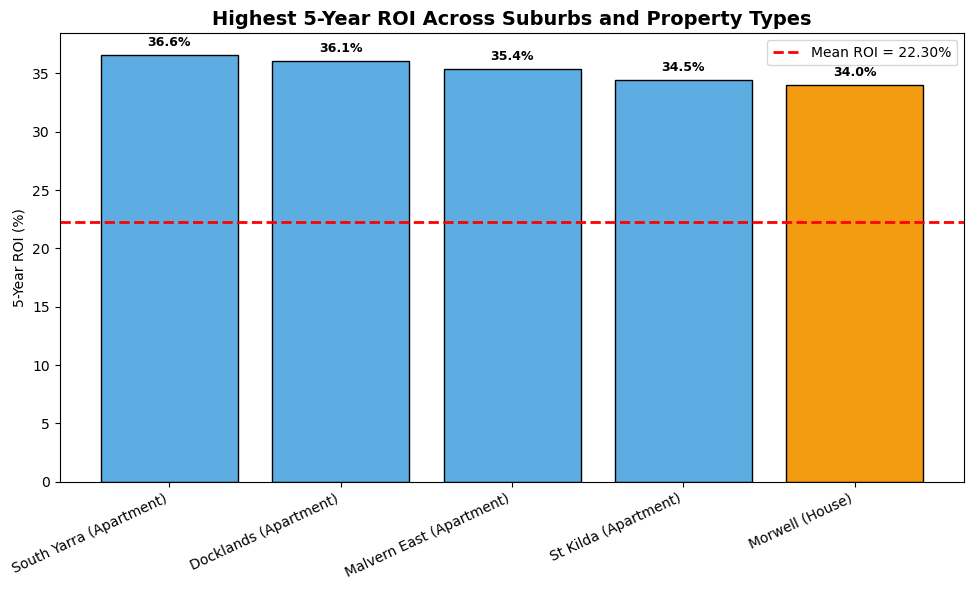

In [95]:
mean_ROI = pd.concat([
    apartments['apartment_5yr ROI (%)'],
    houses['House_5yr ROI (%)']
]).mean()

import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace with your actual DataFrames)
aparts = pd.DataFrame({
    "Suburb": ["SOUTH YARRA", "DOCKLANDS", "MALVERN EAST", "ST KILDA", "DANDENONG"],
    "Annual ROI (%)": [7.320881, 7.220644, 7.081725, 6.893955, 6.776486],
    "5yr ROI (%)": [36.604404, 36.103219, 35.408624, 34.469773, 33.882432],
    "Type": ["Apartment"] * 5
})

hus = pd.DataFrame({
    "Suburb": ["MORWELL", "MILDURA", "SHEPPARTON", "SEYMOUR", "PORTLAND"],
    "Annual ROI (%)": [6.808748, 6.256956, 6.167899, 5.670997, 5.659010],
    "5yr ROI (%)": [34.043738, 31.284781, 30.839493, 28.354986, 28.295052],
    "Type": ["House"] * 5
})

# --- Combine and pick top 5 by 5yr ROI
combined = pd.concat([aparts, hus], ignore_index=True)
top5 = combined.sort_values("5yr ROI (%)", ascending=False).head(5)

# --- Create labels like 'South Yarra (Apartment)'
top5["Label"] = top5["Suburb"].str.title() + " (" + top5["Type"] + ")"

# Color mapping
colors = top5["Type"].map({"Apartment": "#5dade2", "House": "#f39c12"})

plt.figure(figsize=(10,6))
bars = plt.bar(top5["Label"], top5["5yr ROI (%)"], color=colors, edgecolor="black")

# Add value labels
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.5,
             f"{bar.get_height():.1f}%",
             ha="center", va="bottom", fontsize=9, fontweight="bold")

# Add mean line
plt.axhline(mean_ROI, color='red', linestyle='--', linewidth=2, label=f"Mean ROI = {mean_ROI:.2f}%")

plt.legend()
plt.title("Highest 5-Year ROI Across Suburbs and Property Types", fontsize=14, fontweight="bold")
plt.ylabel("5-Year ROI (%)")
plt.xticks(rotation=25, ha="right")

plt.tight_layout()
plt.show()



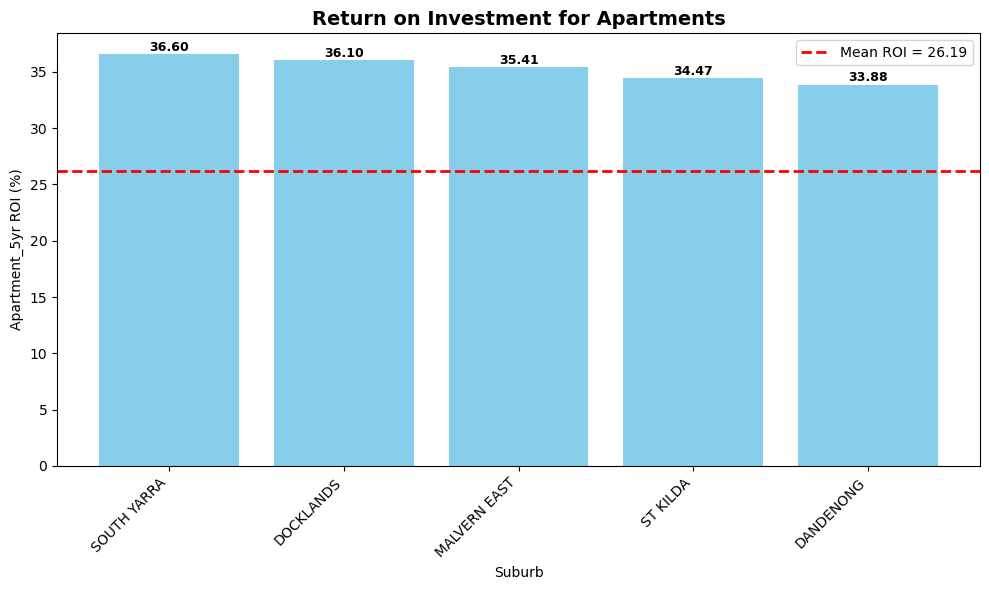

In [96]:


import matplotlib.pyplot as plt
mean_roi = apartments['apartment_5yr ROI (%)'].mean()
# Take top 5 (as you had)
top_apartments = apartments[:5]


plt.figure(figsize=(10,6))
bars = plt.bar(top_apartments['Suburb'], top_apartments['apartment_5yr ROI (%)'], color='skyblue')

# Add value labels above bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.005, 
             f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=9, fontweight="bold")

# Add mean ROI line
plt.axhline(mean_roi, color='red', linestyle='--', linewidth=2, label=f"Mean ROI = {mean_roi:.2f}")

# Title & labels
plt.title("Return on Investment for Apartments", fontsize=14, fontweight="bold")
plt.ylabel("Apartment_5yr ROI (%)")
plt.xlabel("Suburb")

# Rotate x labels
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend()

plt.tight_layout()
plt.show()



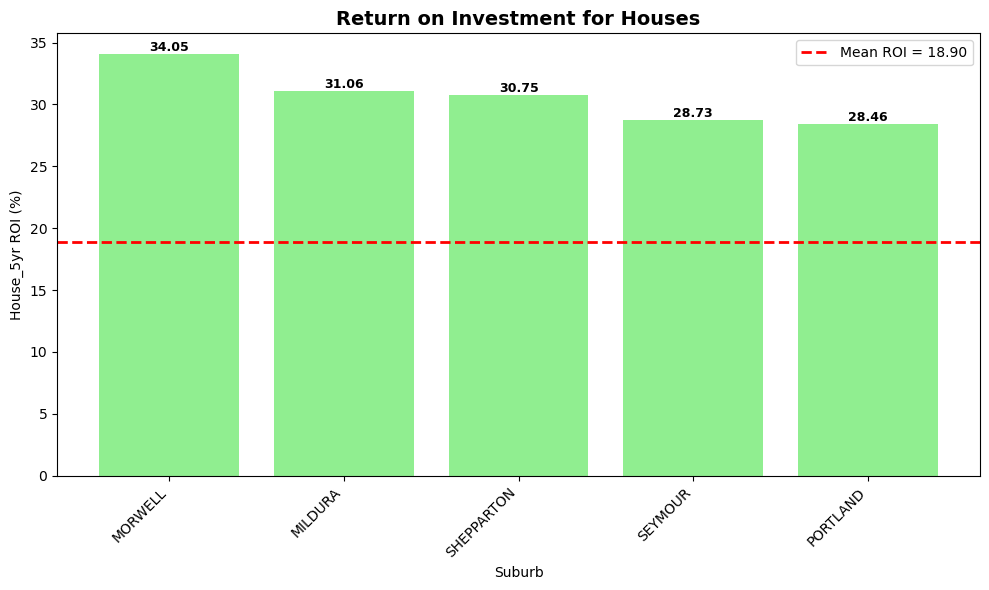

In [97]:
import matplotlib.pyplot as plt

# Calculate mean ROI across all houses
mean_roi = houses['House_5yr ROI (%)'].mean()

# Take top 5 (if you want only top 5 suburbs, otherwise keep full dataframe)
top_houses = houses[:5]

plt.figure(figsize=(10,6))
bars = plt.bar(top_houses['Suburb'], top_houses['House_5yr ROI (%)'], color='lightgreen')

# Add value labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.005,
             f"{bar.get_height():.2f}",
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add mean ROI line
plt.axhline(mean_roi, color='red', linestyle='--', linewidth=2,
            label=f"Mean ROI = {mean_roi:.2f}")

# Title & labels
plt.title("Return on Investment for Houses", fontsize=14, fontweight='bold')
plt.ylabel("House_5yr ROI (%)")
plt.xlabel("Suburb")

# Rotate x labels for readability
plt.xticks(rotation=45, ha="right")

# Add legend for the mean line
plt.legend()

plt.tight_layout()
plt.show()


In [98]:
(all['max_annual_roi'].max()*5 - all['max_annual_roi'].mean()*5)/(all['max_annual_roi'].mean()*5)*100

44.63271212044389

In [99]:
import re
import pandas as pd

df = all.copy()  # or whatever your dataframe is called

# ---- 1) Collect forecast columns like "..._2025_avg", "..._2030_avg"
year_cols = [c for c in df.columns if re.search(r'_(20\d{2})_avg$', c)]
years = pd.Index([re.search(r'_(20\d{2})_avg$', c).group(1) for c in year_cols])

# Build a (rows x forecast-years) table by averaging across property types per year
rents_by_year = df[year_cols].copy()
rents_by_year.columns = years                # duplicate year labels across types
avg_rent_by_year = rents_by_year.groupby(level=0, axis=1).mean()  # mean across types for each year

# Optional: add these year-wise means back onto df with readable names
avg_rent_by_year_renamed = avg_rent_by_year.add_prefix('avg_rent_all_')
df = pd.concat([df, avg_rent_by_year_renamed], axis=1)

# ---- 2) Today's average rent across all property types (any column ending with "_Rent_today")
today_cols = [c for c in df.columns if c.endswith('_Rent_today')]
if today_cols:
    df['avg_rent_today_all'] = df[today_cols].mean(axis=1)

# ---- 3) Mean YoY % change across forecast years (e.g., 2025→2026, …)
# pct_change across columns (time flows left→right if columns sorted)
avg_rent_by_year = avg_rent_by_year.sort_index(axis=1)  # ensure 2025,2026,... order
yoy_pct = avg_rent_by_year.pct_change(axis=1) * 100
df['avg_annual_change_pct'] = yoy_pct.iloc[:, 1:].mean(axis=1)  # mean of available YoY moves

# ---- 4) CAGR across forecast horizon (first→last forecast year)
first_y, last_y = avg_rent_by_year.columns[0], avg_rent_by_year.columns[-1]
n_years = int(last_y) - int(first_y)  # e.g., 2030-2025 = 5
start_vals = avg_rent_by_year[first_y]
end_vals   = avg_rent_by_year[last_y]
df['cagr_all_pct'] = ((end_vals / start_vals) ** (1 / n_years) - 1) * 100

# df now has:
#   - avg_rent_all_2025 ... avg_rent_all_2030
#   - avg_rent_today_all (if *_Rent_today exist)
#   - avg_annual_change_pct
#   - cagr_all_pct


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_16047/1571478217.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_rent_by_year = rents_by_year.groupby(level=0, axis=1).mean()  # mean across types for each year
/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_16047/1571478217.py:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yoy_pct = avg_rent_by_year.pct_change(axis=1) * 100


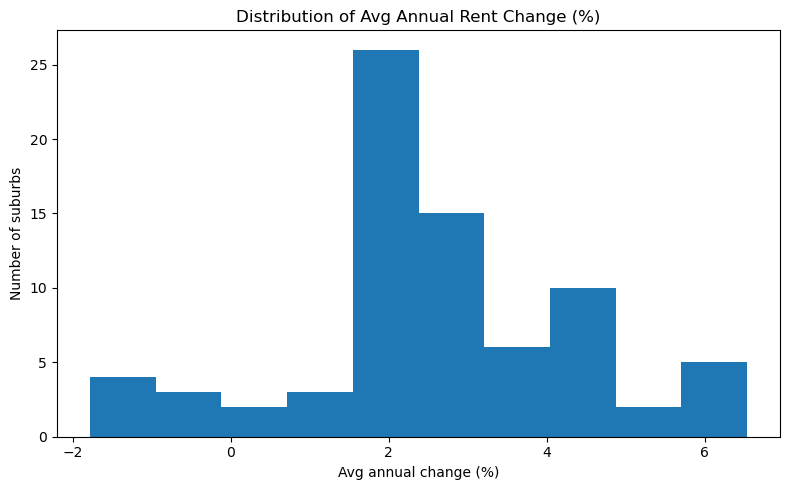

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(df['avg_annual_change_pct'].dropna(), bins=10)
plt.title('Distribution of Avg Annual Rent Change (%)')
plt.xlabel('Avg annual change (%)'); plt.ylabel('Number of suburbs'); plt.tight_layout(); plt.show()


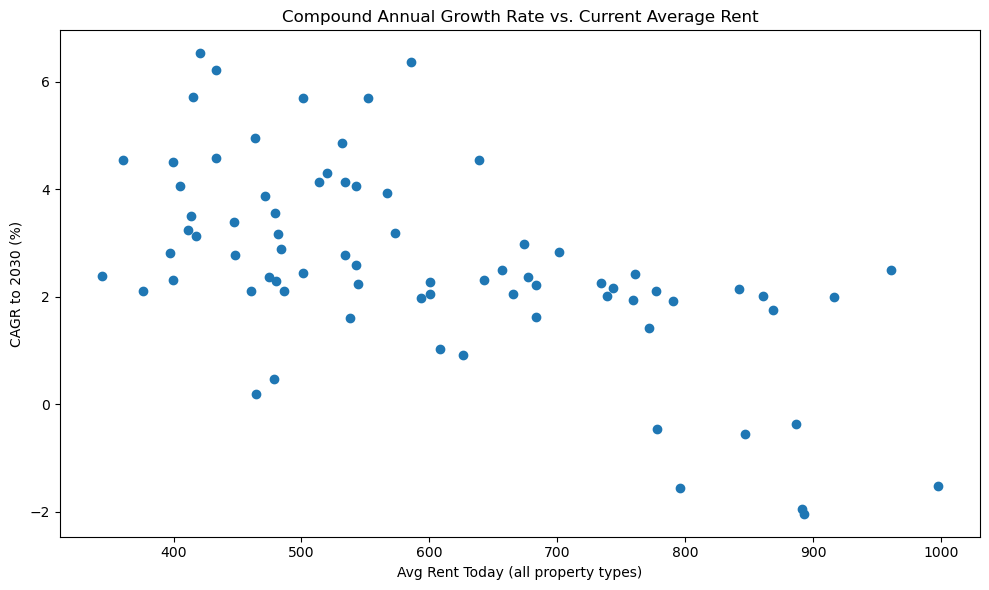

In [101]:
top = df  # or whatever slice you want
plt.figure(figsize=(10,6))
plt.scatter(top['avg_rent_today_all'], top['cagr_all_pct'])
plt.title('Compound Annual Growth Rate vs. Current Average Rent')
plt.xlabel('Avg Rent Today (all property types)')
plt.ylabel('CAGR to ' + last_y + ' (%)')
plt.tight_layout(); plt.show()


<Axes: >

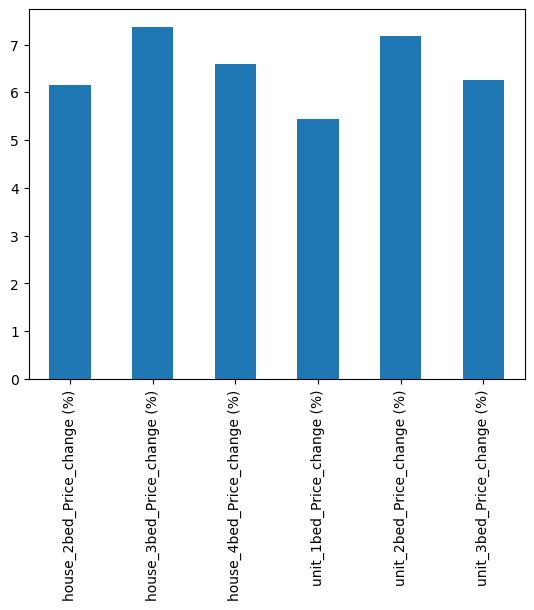

In [102]:
columns = [
 'house_2bed_Price_change (%)',
 'house_3bed_Price_change (%)',
 'house_4bed_Price_change (%)',
 'unit_1bed_Price_change (%)',
 'unit_2bed_Price_change (%)',
 'unit_3bed_Price_change (%)',
]

df[columns].mean().plot(kind="bar")

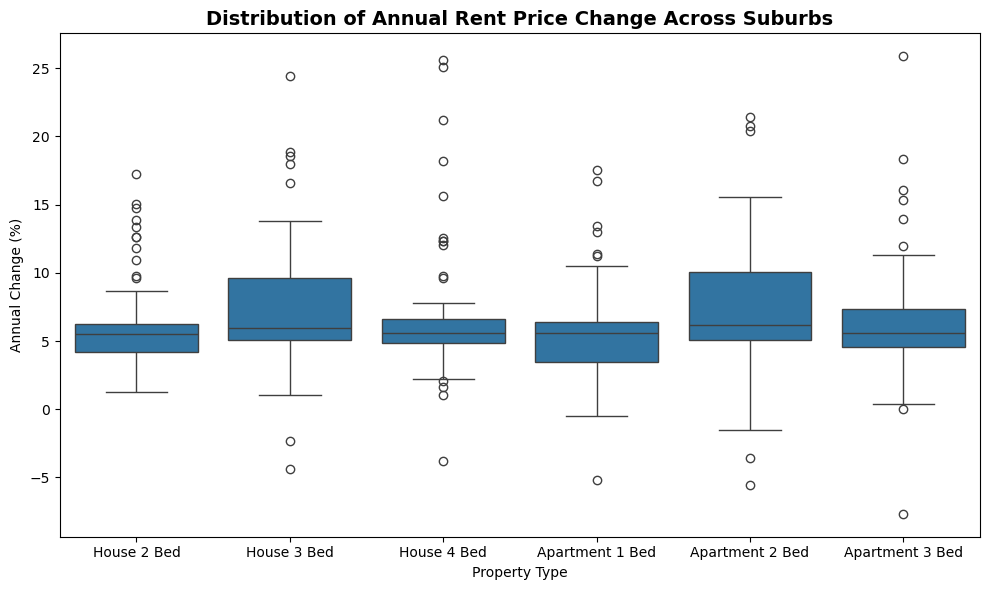

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# dictionary to rename columns
rename_map = {
    'house_2bed_Price_change (%)': 'House 2 Bed',
    'house_3bed_Price_change (%)': 'House 3 Bed',
    'house_4bed_Price_change (%)': 'House 4 Bed',
    'unit_1bed_Price_change (%)': 'Apartment 1 Bed',
    'unit_2bed_Price_change (%)': 'Apartment 2 Bed',
    'unit_3bed_Price_change (%)': 'Apartment 3 Bed'
}

# melt into long format
price_change_cols = list(rename_map.keys())
data_long = df[price_change_cols].melt(
    var_name="Property Type",
    value_name="Annual Change (%)"
)

# apply renaming
data_long["Property Type"] = data_long["Property Type"].map(rename_map)

# plot
plt.figure(figsize=(10,6))
sns.boxplot(x="Property Type", y="Annual Change (%)", data=data_long)
plt.title("Distribution of Annual Rent Price Change Across Suburbs", fontsize=14, fontweight="bold")
plt.xticks(rotation=0)  # keep labels horizontal
plt.tight_layout()
plt.savefig("../graphs/price_change_distribution.png")
